# Goals of this meeting
1. Intuitive understanding of the back propagation
2. Intuitive understanding of the gradient vanishing problem
3. Use LSTM and GRU using Keras

# References
* [1] http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/ 
* [2] http://colah.github.io/posts/2015-08-Backprop/
* http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/
* [3] Pascanu, Razvan, Tomas Mikolov, and Yoshua Bengio. "On the difficulty of training recurrent neural networks." ICML 2013
* [4] http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* [5] http://r2rt.com/styles-of-truncated-backpropagation.html
* [6] page 23 of Ilya Sutskever’s Ph.D. thesis http://www.cs.utoronto.ca/~ilya/pubs/ilya_sutskever_phd_thesis.pdf

# Summary
* Back propagation is a "technique of calculating a gradient descent quickly" [1]. In my opinion, it is just a dynamic programming.
* Visualization of chain rules using computation graph is helpful for intuitive understanding of vanishing gradient problem that occurs in normal RNN.
* To relax the vanishing gradient problem, one approach is to use LSTMs or GRUs. 

# High-level overview of Recurrent Neural Networks (RNNs)

* $x_t$: Input. Typically it is a word vector, but it can also be a scalar.
* $h_t$: Output. Typically it is a vector, but it can also be a scalar.

The following image is from [4]:

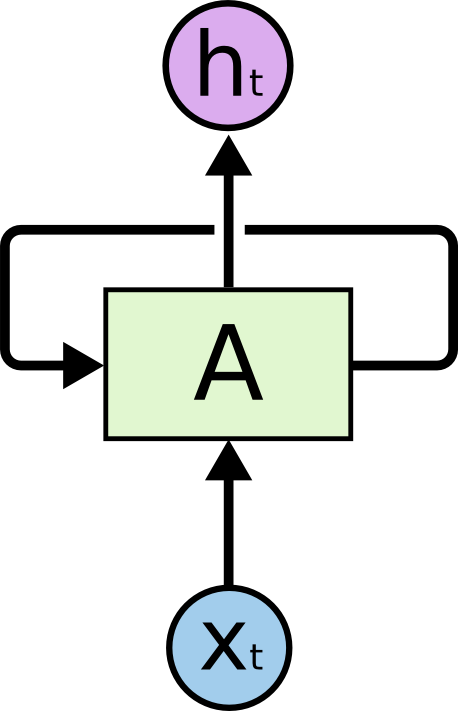

In [3]:
from IPython.display import Image
Image(filename='figures/RNN-rolled.png', width=200)

If we unroll this recurrence connection according to time $t$, then we get the following figure (from [4]):

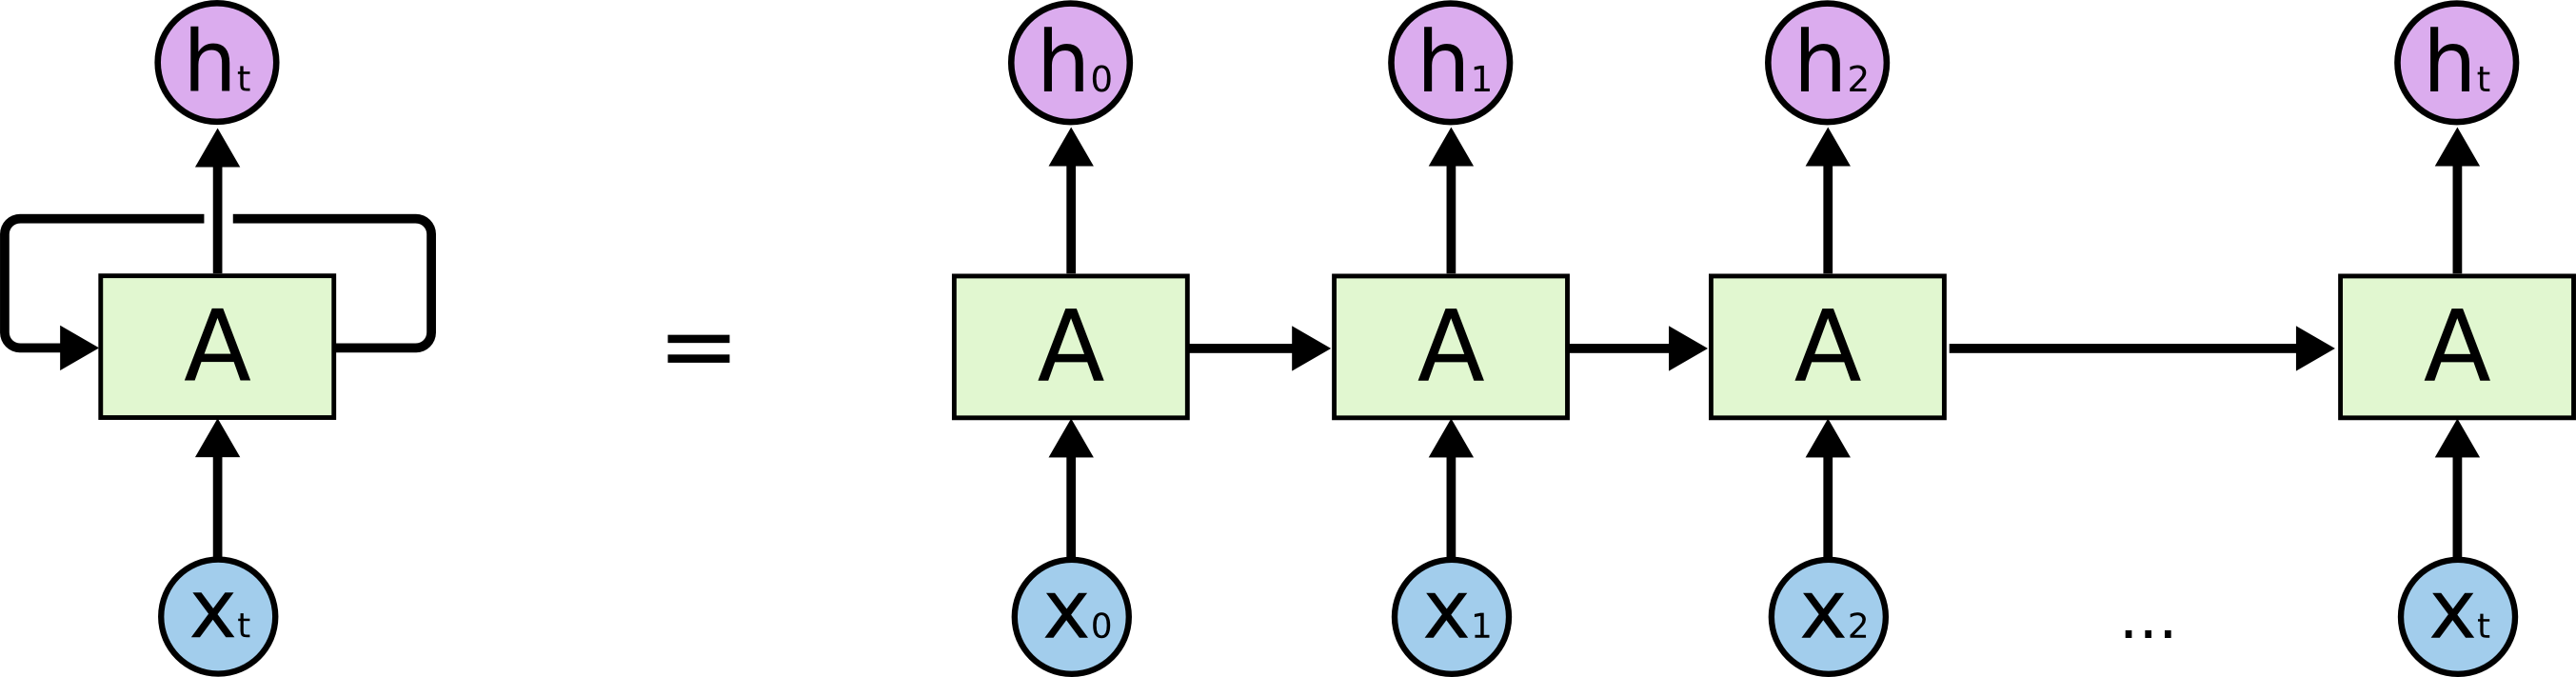

In [8]:
from IPython.display import Image
Image(filename='figures/RNN-unrolled.png', width=800)

## Training an RNN model

### Truncation of Back Propagation Through Time (BPTT)


#### Tensorflow version (num_steps = 3)
Tensorflow controls the turncation parameter through "num_steps" variable (https://www.tensorflow.org/tutorials/recurrent#truncated-backpropagation).

In [9]:
from IPython.display import Image
Image(filename='figures/RNN_tf_truncated_backprop.png', width=600)

This form have problems capturing dependencies beoyon "num_steps".

In Ilya Sutskever’s Ph.D. thesis [6] and [5], they talk about other variants of turncated back propagation.

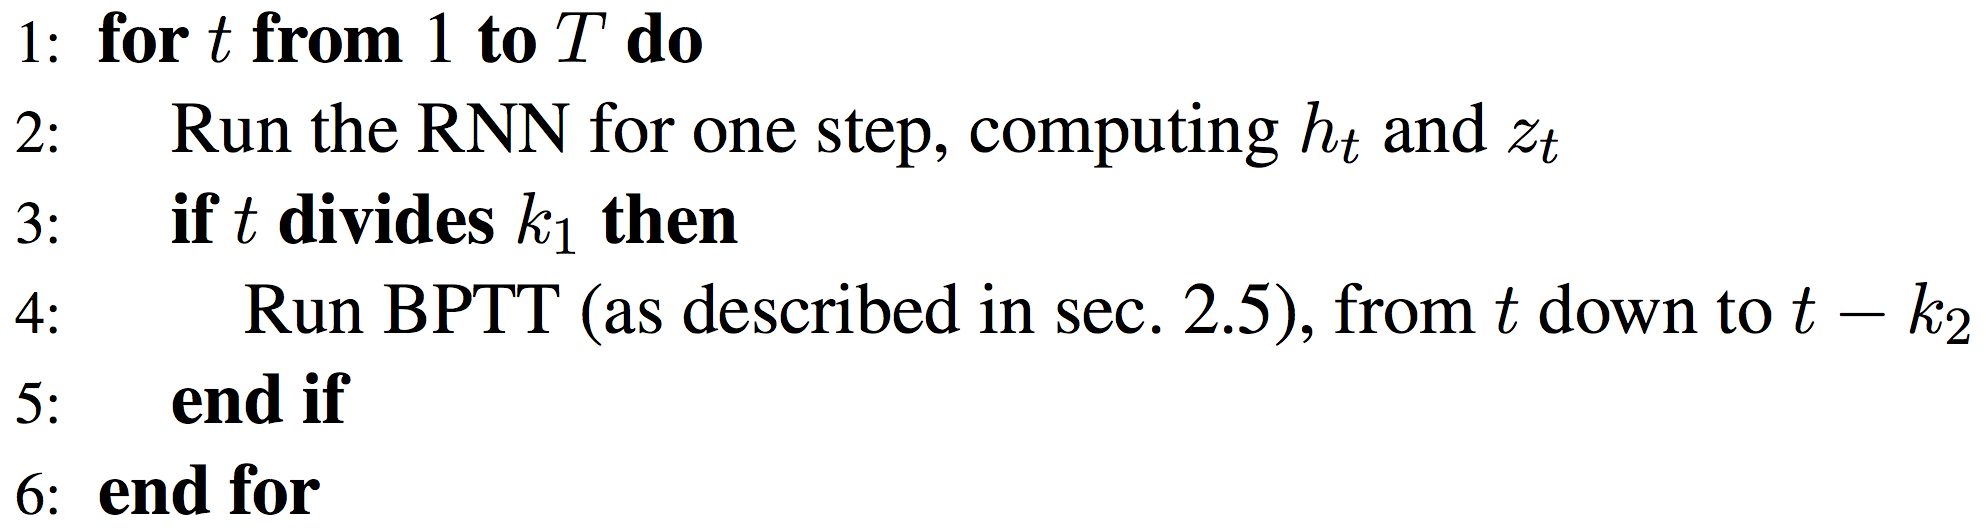

In [10]:
from IPython.display import Image
Image(filename='figures/ilya_phd_thesis_bptt_truncate.png', width=600)

As mentioned in [5], the Tensorflow implementation is when $k_1 = k_2 = num\_steps$.

If you want to capture  longer range dependencies than $num\_steps$, then one way is to set $k_2 << k_1$, for example $k_2 = 1$. The following figure is the case when $k_1 = 3$ and $k_2 = 1$ (which I borrowed from [5]):

In [12]:
from IPython.display import Image
Image(filename='figures/RNN_true_truncated_backprop.png', width=600)

I will borrow Ilya Sutskever's words: "Consequently, its hidden states have been exposed to many timesteps and so may contain useful information about the far past, which would be opportunistically exploited."

Specifically, in this case, the 3rd RNN cell is exposed 2 more times than the Tensorflow implementaiton.

# Intuitive Explanation of Back Propagation

### Why is the chain rule in derivatives important for training neural networks?

Chain rule is applied when computing derivatives of a function composed by two or more functions (according to Wikipedia https://en.wikipedia.org/wiki/Chain_rule)

Chian rule is important when training a neural network because one nueron is dependent on another.
This is the same case for RNNs. Let's be more precious and use a variable to define RNNs. Check out the following figure (from [1]) to get an intuitive idea of it.

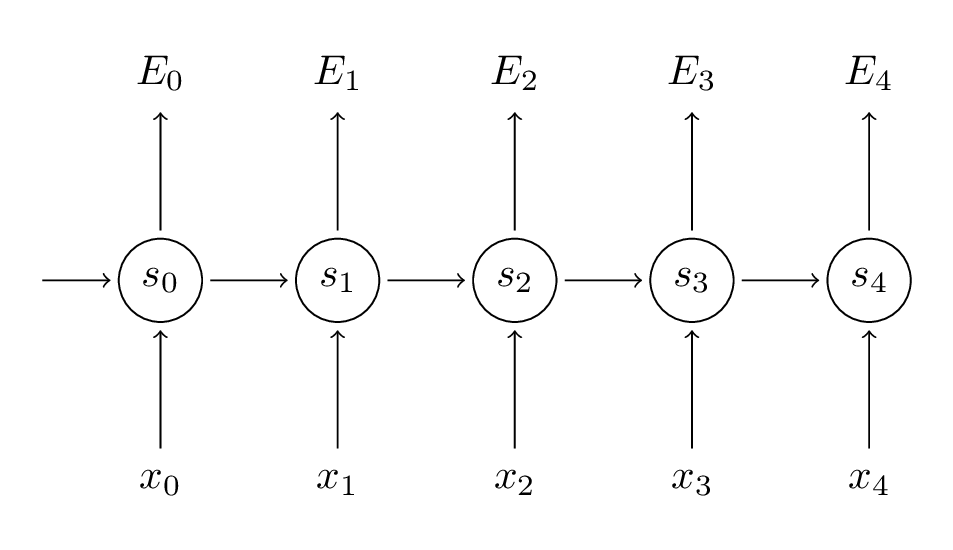

In [14]:
from IPython.display import Image
Image(filename='figures/rnn-bptt1.png', width=600)

$E_t$: is the error at time $t$. It is typically defined as categorical cross-entropy i.e. 
$$
E_t = -y_t \log(\hat{y_t})
$$
And the total loss will be
$$
E = \frac{1}{N}\sum_t^N -y_t \log(\hat{y_t})
$$


$s_2$ requires $s_1$, which is also dependent on a variable $s_0$.


### Visualization of Chian Rules using Computation Graph [2]

The visualiztion of chain rules useful the intuitive understanding of the vanishing gradient problem. In my opinion, there are two difficulties in understanding the theory behing gradient vanishing problem:

1. Computation of gradient using the cost function involves many paraemters that are dependent on each other, so we have to apply the chain rule.
2. Computation of gradient involves vector calculus which is harder to understand than scalar calculus.

To get ready to dive deep into to these two points, let's do a simple back propagation example on a simple function (folowing step by step presented in [1]). 

Assume we are focusing on the following function (which corresponds to the cost function in the neural network training settings):

\begin{equation}
f(c, d) = c d \\
c = a + b \\
d = b + 1 \\
\end{equation}

The compuation graph of chain rules is the following (image ref [1]):

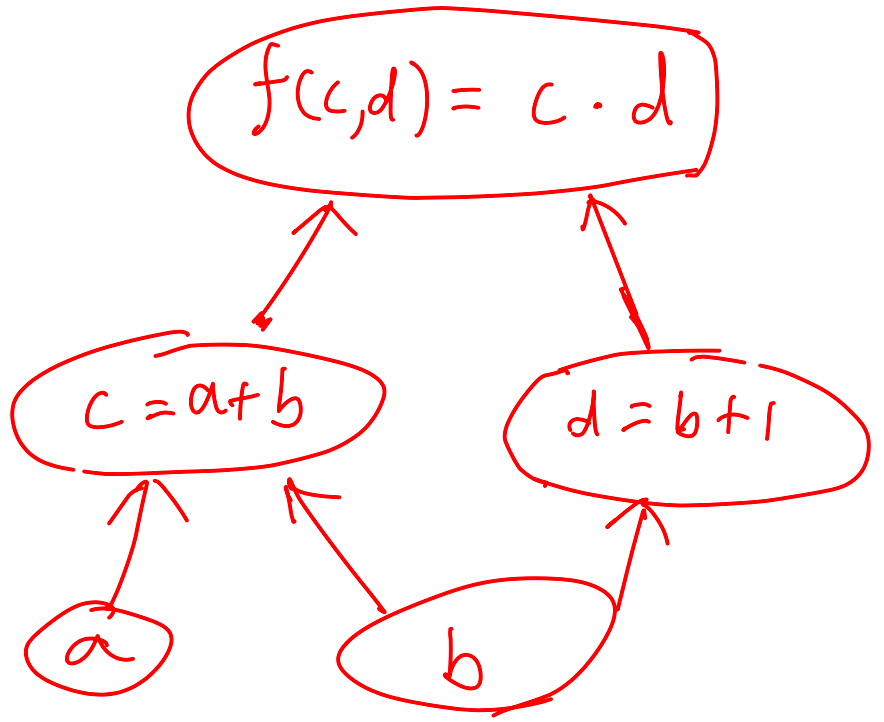

In [16]:
from IPython.display import Image
Image(filename='figures/computation_graph_1.png', width=300)

What is good about this graph? The answer is, you can now just compute the derivative of each node by summing up all the product of derivatives!

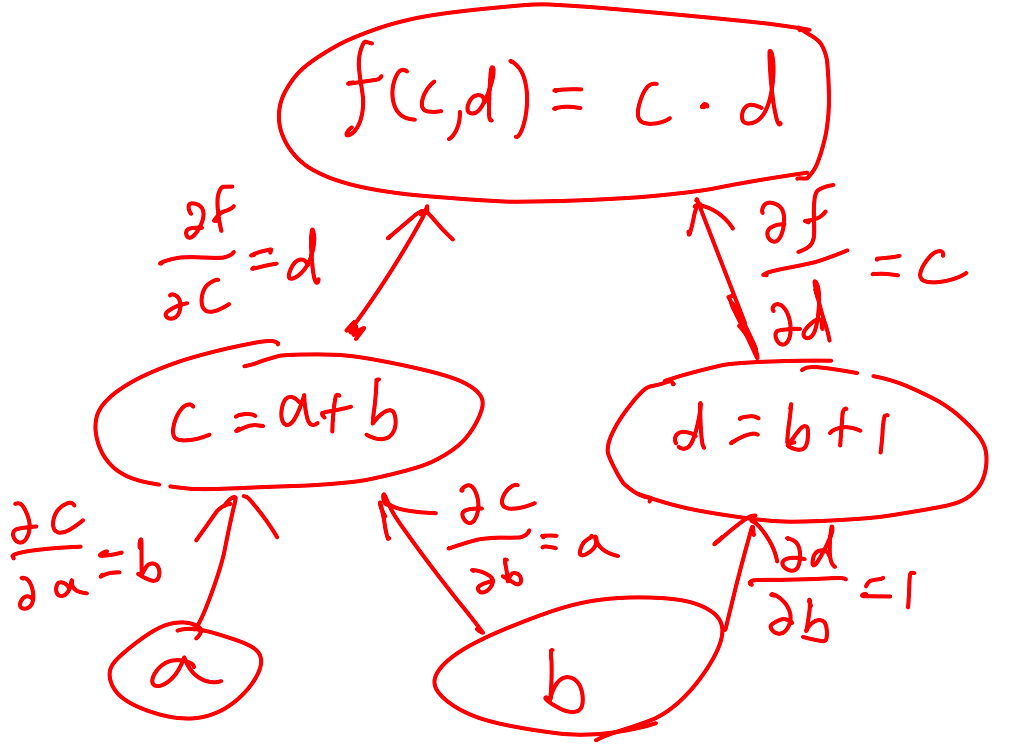

In [17]:
from IPython.display import Image
Image(filename='figures/computation_grpah_2_with_derivatives_edges.png', width=300)

The chain rule applied to $f(c, d)$ is
\begin{align}
\frac{\partial f(c, d)}{\partial a} 
&= \frac{\partial f}{\partial c} \frac{\partial c}{\partial a} \\
&= d * b
\end{align}
and 

\begin{align}
\frac{\partial f(c, d)}{\partial b} 
&= \frac{\partial f}{\partial b} \frac{\partial d}{\partial b} +  \frac{\partial f}{\partial c} \frac{\partial c}{\partial b} \\
&= c * 1 + d * a
\end{align}

Notice that it is simply following the all possible path in this graph (bottom to up) from input variables $a, b$.

### Back propagation

Notice that when looking into the equations, there are derivatives that are shared among two equations, namely $\frac{\partial f}{\partial c} $?
So if we naively compute the derivatives (or gradients in higher dimension) on each variable, it is computing the derivation on $\frac{\partial f}{\partial c} $ multiple times (well, twice in this case though).

Solution? **Dynamic programming** or in this particular application, there is a fancy name **backpropagation**.

Now let's do the opposite i.e. going from up to bottom in this graph:

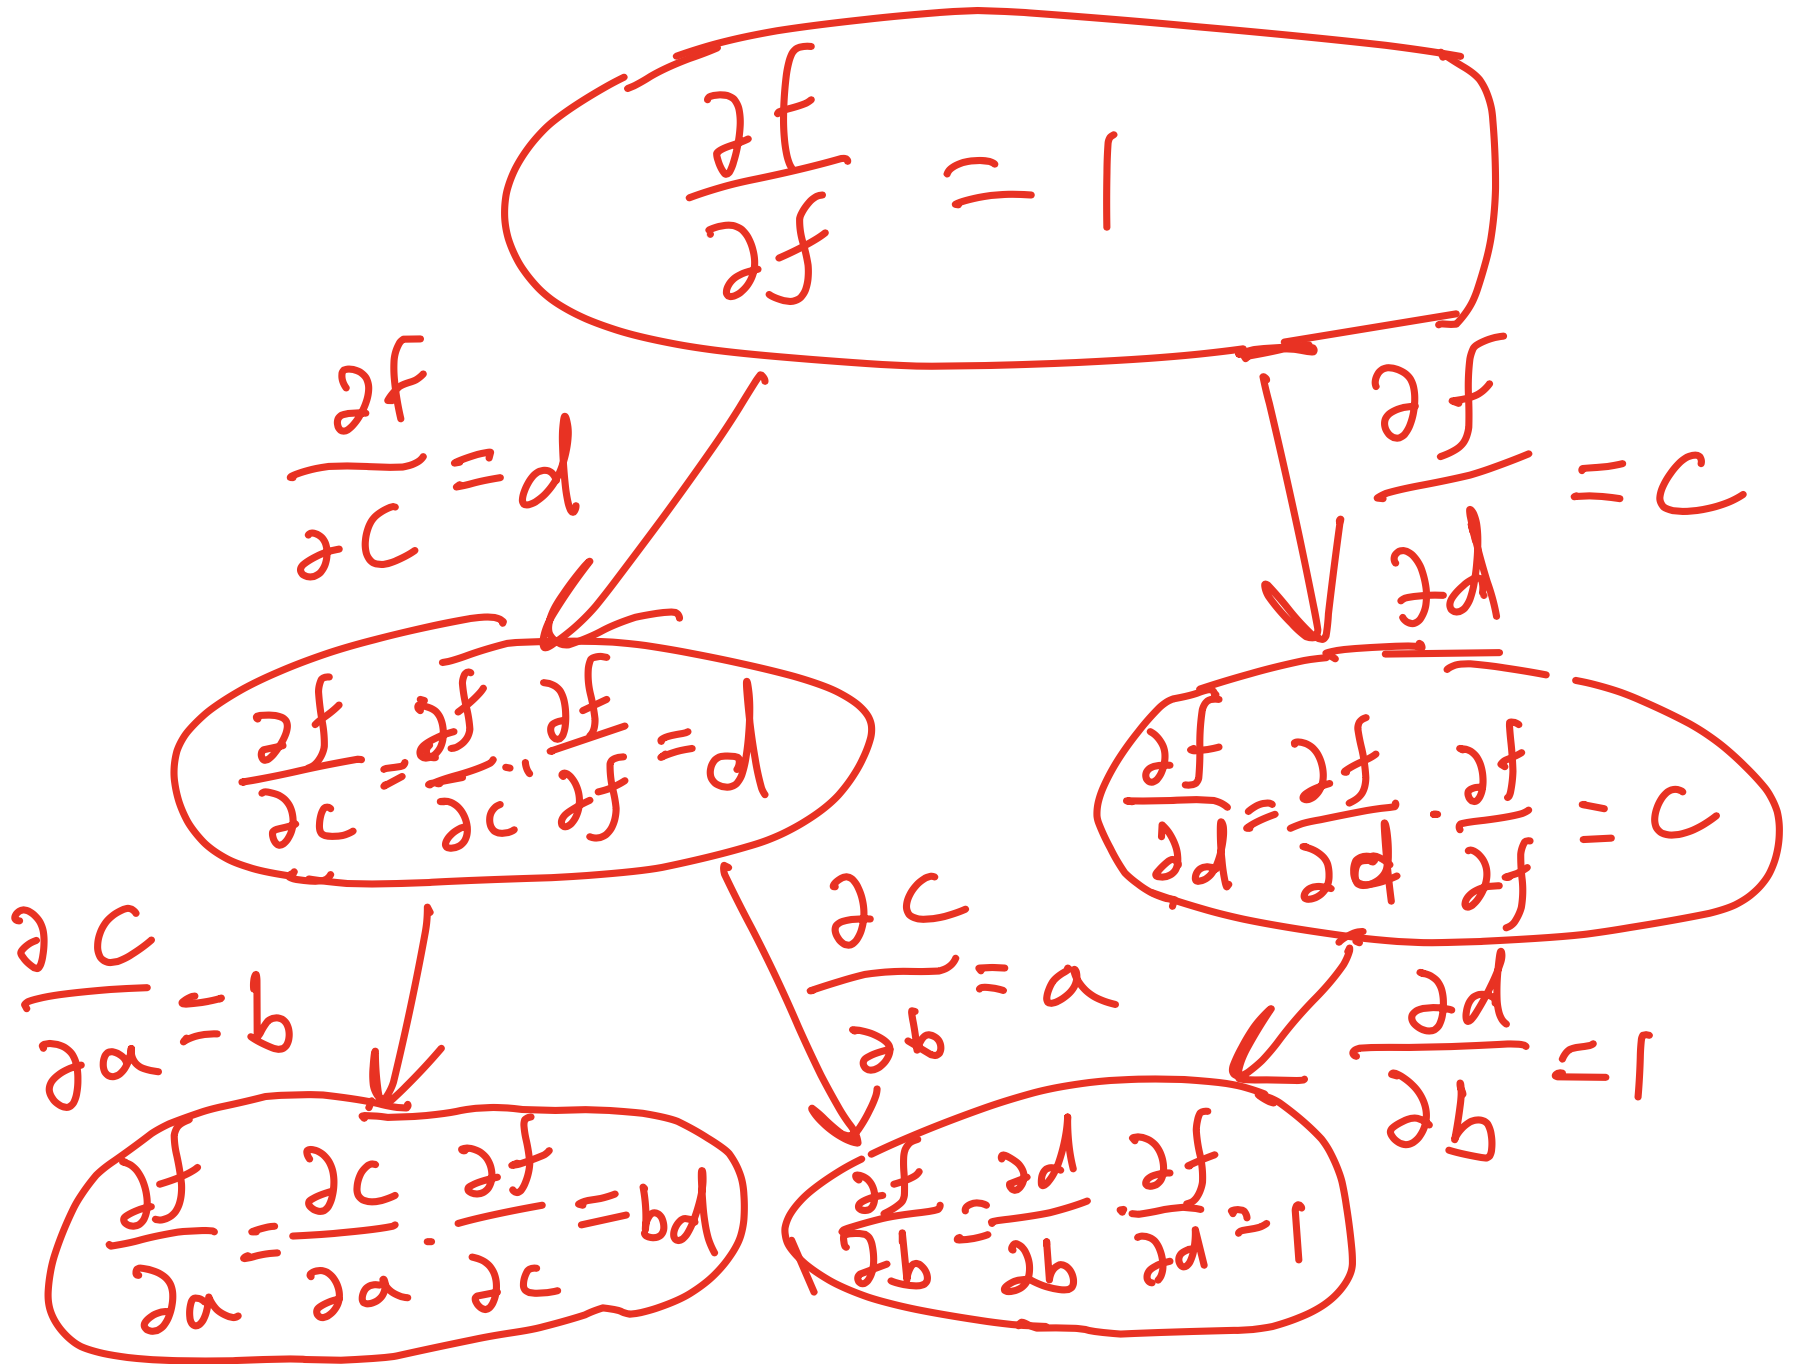

In [20]:
from IPython.display import Image
Image(filename='figures/computation_graph_3_back_prop.png', width=300)

So going from up to bottom and bottom to up is almost the same **except that you traverse only once per edge for the top to bottom traversal**. This is because the computational graph created from chain rule can have multiple children per node.

In the nueral network case, the bottom nodes (or the leaf nodes) are the weight parameters $W$ and the biases $b$. When the number of these parameters are large, it saves a LOT of time to compute the gradient according to each parameter.

## Intuitive Explanation of Gradient Vanishing Problem
How is the back propagation related to the vanishing gradient on the standard RNNs?

I am not going into mathematical details since I infer it will covered in Jordan's class, but I can explain the intuitive understanding.

The example I borrowed from [1] is the case of scalar or one-dimensional vector with a pretty shallow graph. What is the compuational graph created by chain rule for the simple RNN?

### Simple Recurrent Neural Network (RNN)

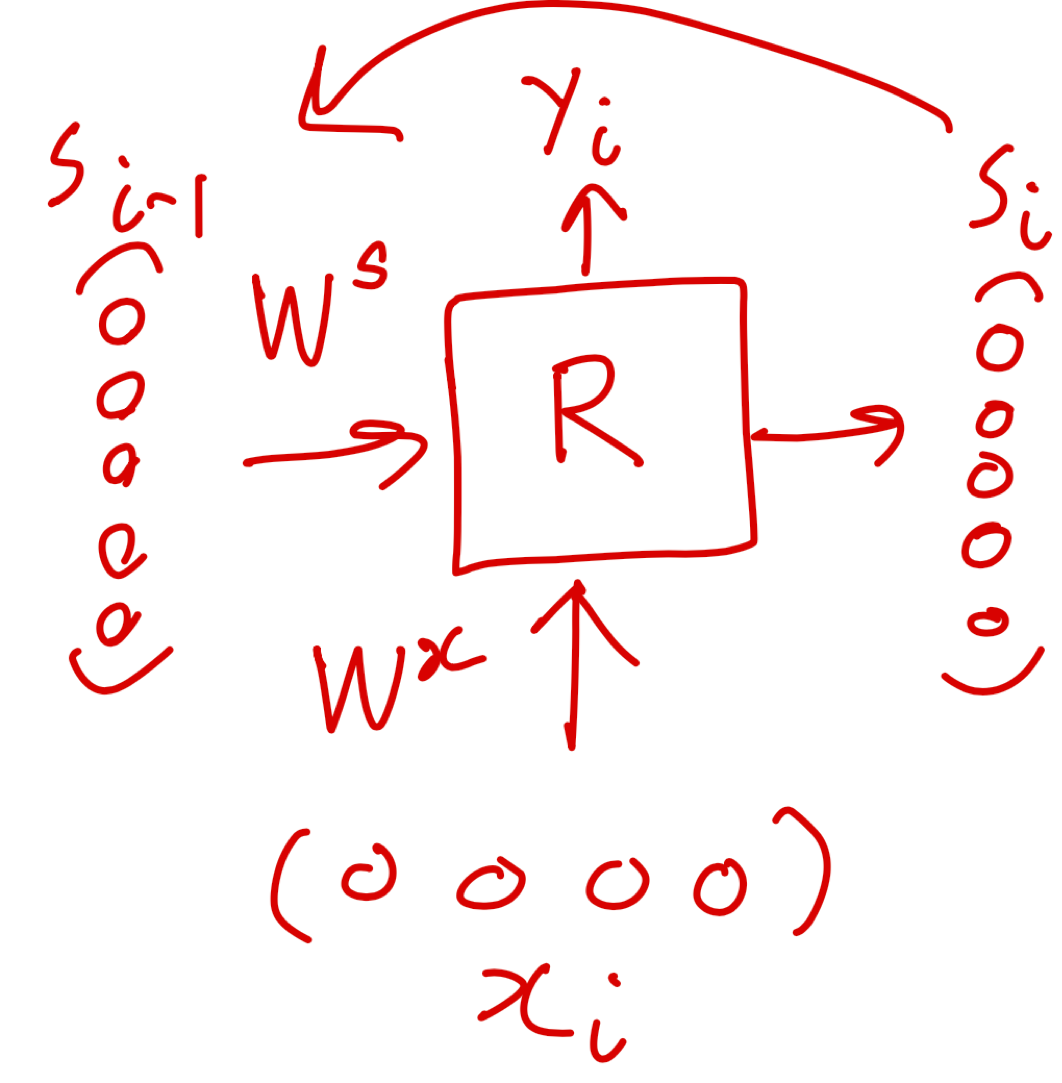

In [7]:
from IPython.display import Image
Image(filename='figures/rnn_cell.png', width=300)

## List of variables and what they mean
* $s_i$: State vector with dimension $d_s$
* $x_i$: Input vector with dimension $d_x$
* $y_i$: Output vector
* $W^x$: Weight matrix for the input vector $x_i$ with dimension $d_x \times d_s$
* $W^s$: Weight matrix for the state trainstion between state $s_{i-1}$ and $s_i$ with dimension $d_s \times d_s$
* $R$: Recurrent function.
* $b$: bias vector
* $\sigma$: activation function (typically $tanh$ or ReLU)

## Definition of $y_i$ and $s_i$
* $s_i = R(x_i, s_{i-1}, b) = \sigma(W^x x_i + W^s s_{i-1} + b)$
* $y_i = s_i$ or it is a softmax function for classification problems

When constructing the compuational graph for RNN, the key part is $s_{t-1} \rightarrow s_t$.

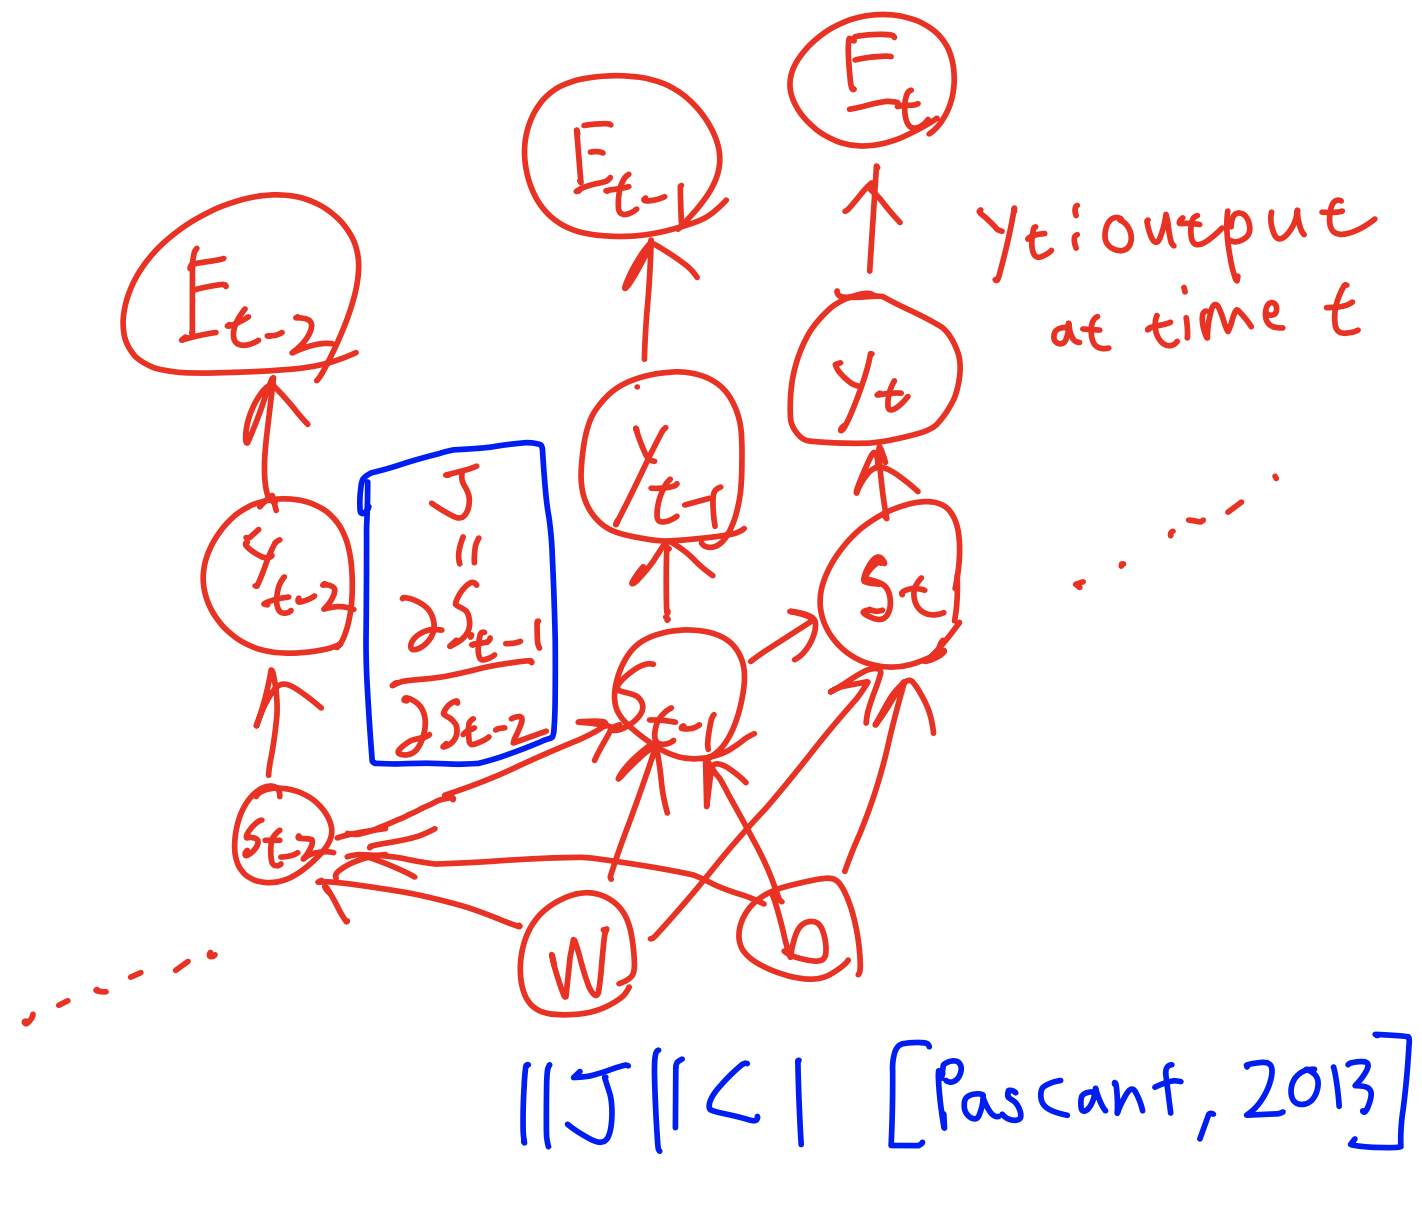

In [21]:
Image(filename='figures/computational_graph_4_rnn.png', width=600)

$J$ is a Jacobian matrix is the vector extension of first-order partial derivatives. (FYI, the second-order one is called Hessian matrix)

So remember from our fist example that when we backprogate from the top node to bottom node, **we multiply the partial derivatives that corresponds to each edge**.
Also, notice that there is only one edge from $t-1$ nodes to $t$ nodes, namely $s_{t-1} \rightarrow s_{t}$.

In [3], there is a proof that the determinant of the Jacobian matrix betwen $s_{t-1}$ and $s_{t}$ is less than 1. 
In other words,** every time we backpropagate through $s_{t-1} \leftarrow s_{t}$, the gradient value which we are currently holding will decrease!**

$\therefore$ the standard RNN will not capture the long range dependencies.

# LSTM


## Overview of LSTM

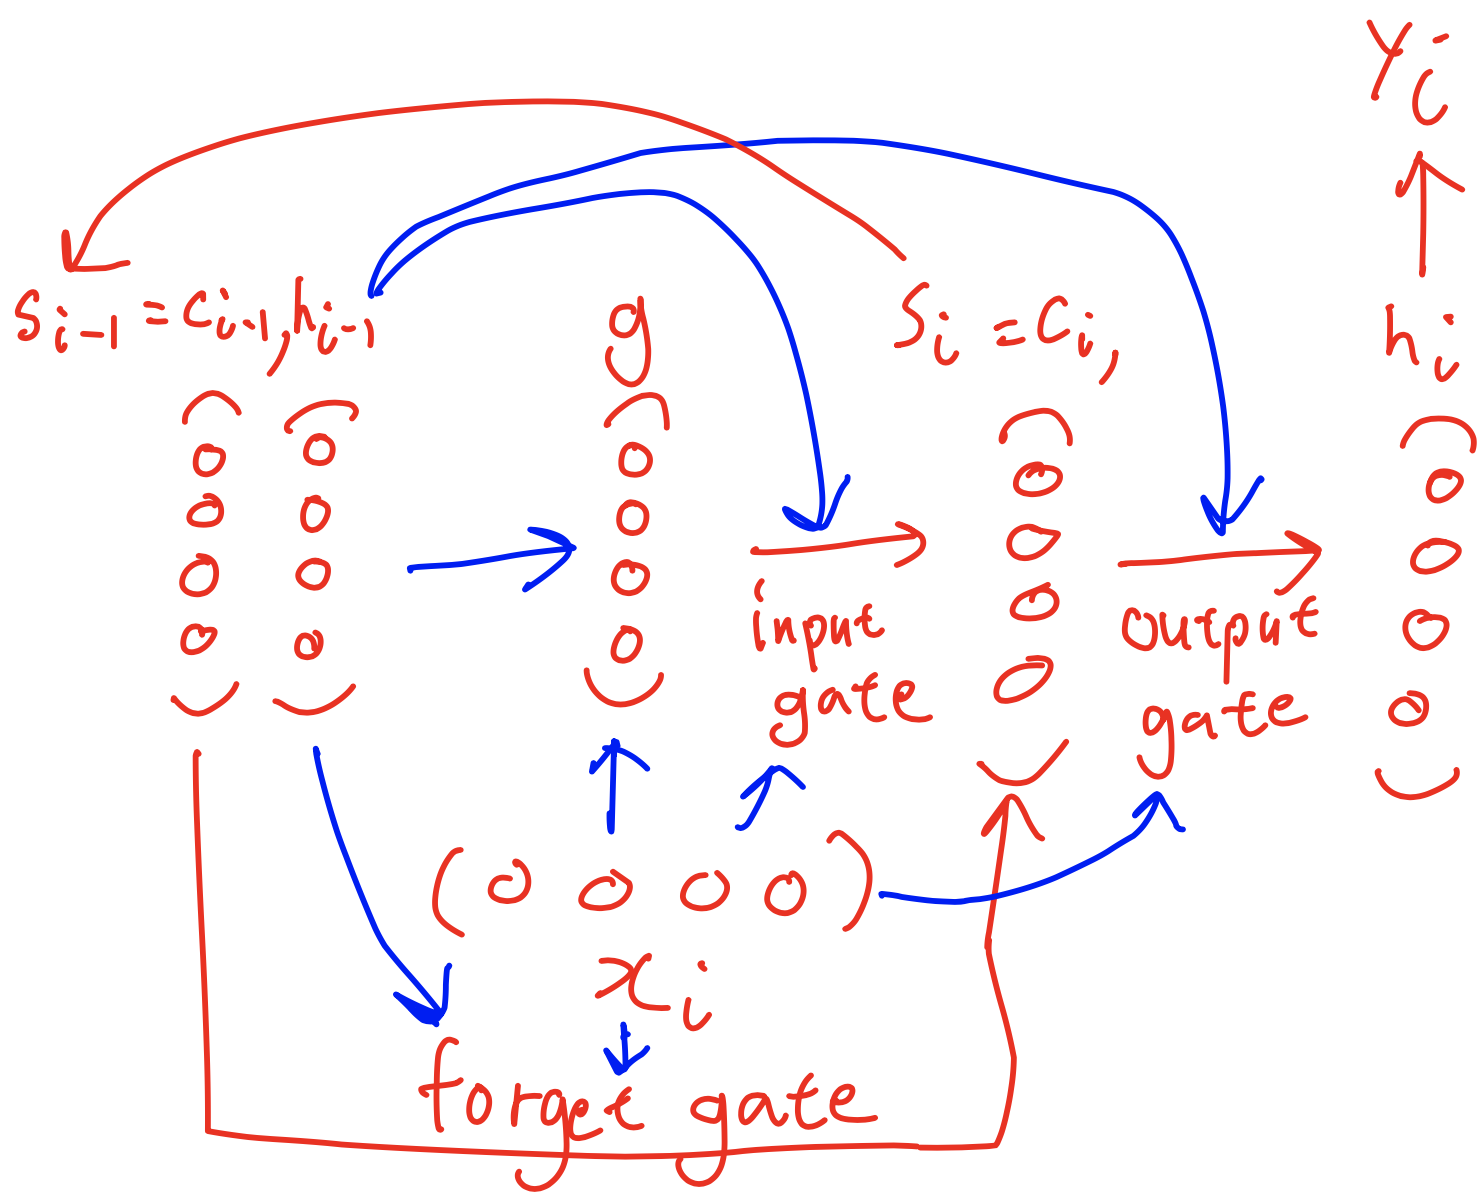

In [12]:
Image(filename='figures/lstm_cell.png', width=600)

# Toy example: Tweet2vec